In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from modules.training import train_model, evaluate_metrics

import os
from torchvision import transforms
from torchvision import datasets, transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import modules.custom_transforms as custom_transforms
import modules.augmenting as augmenting
import matplotlib.pyplot as plt

gamma = 0.95

In [2]:
# Define a simple NN
class SimpleNN(nn.Module):
    def __init__(self, X, Y):
        super().__init__()
        self.fc1 = nn.Linear(X.shape[1], len(torch.unique(Y)))
        print(self.fc1)

        # Loss and optimizer are defined here:
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=gamma)

    def forward(self, x):
        x = self.fc1(x)
        # x = self.softmax(x)
        return x

In [3]:
# Load the validation data
data_val = torch.load('data_images/valid.pt')
X_val = data_val['Features']  # shape: (N, H)
Y_val = data_val['Targets']  # shape: (N,)
print(X_val.shape, Y_val.shape)

data_test = torch.load('data_images/test.pt')
X_test = data_test['Features']  # shape: (N, H)
Y_test = data_test['Targets']  # shape: (N,)
print(X_test.shape, Y_test.shape)

# Create DataLoaders
batch_size = 32

val_ds = TensorDataset(X_val, Y_val)
val_loader = DataLoader(val_ds, batch_size=len(Y_val), shuffle=False)

test_ds = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_ds, batch_size=len(Y_test), shuffle=False)

torch.Size([72, 512]) torch.Size([72])
torch.Size([315, 512]) torch.Size([315])


# 1. Import data post-CNN and train a shallow network 
-> Best results

To avoid data augmentation, use X_train = X_train[:613] and same for y

Linear(in_features=512, out_features=4, bias=True)
Epoch 1/100 | Train Loss: 65.313 | Train Acc: 0.495 | Val Acc: 0.500
Epoch 2/100 | Train Loss: 48.248 | Train Acc: 0.647 | Val Acc: 0.528
Epoch 3/100 | Train Loss: 42.923 | Train Acc: 0.701 | Val Acc: 0.569
Epoch 4/100 | Train Loss: 39.020 | Train Acc: 0.732 | Val Acc: 0.556
Epoch 5/100 | Train Loss: 35.994 | Train Acc: 0.774 | Val Acc: 0.653
Epoch 6/100 | Train Loss: 33.134 | Train Acc: 0.791 | Val Acc: 0.653
Epoch 7/100 | Train Loss: 31.801 | Train Acc: 0.801 | Val Acc: 0.667
Epoch 8/100 | Train Loss: 29.946 | Train Acc: 0.823 | Val Acc: 0.667
Epoch 9/100 | Train Loss: 28.265 | Train Acc: 0.833 | Val Acc: 0.681
Epoch 10/100 | Train Loss: 27.223 | Train Acc: 0.835 | Val Acc: 0.681
Epoch 11/100 | Train Loss: 26.054 | Train Acc: 0.848 | Val Acc: 0.708
Epoch 12/100 | Train Loss: 25.226 | Train Acc: 0.853 | Val Acc: 0.681
Epoch 13/100 | Train Loss: 24.351 | Train Acc: 0.866 | Val Acc: 0.708
Epoch 14/100 | Train Loss: 23.876 | Train Acc: 0

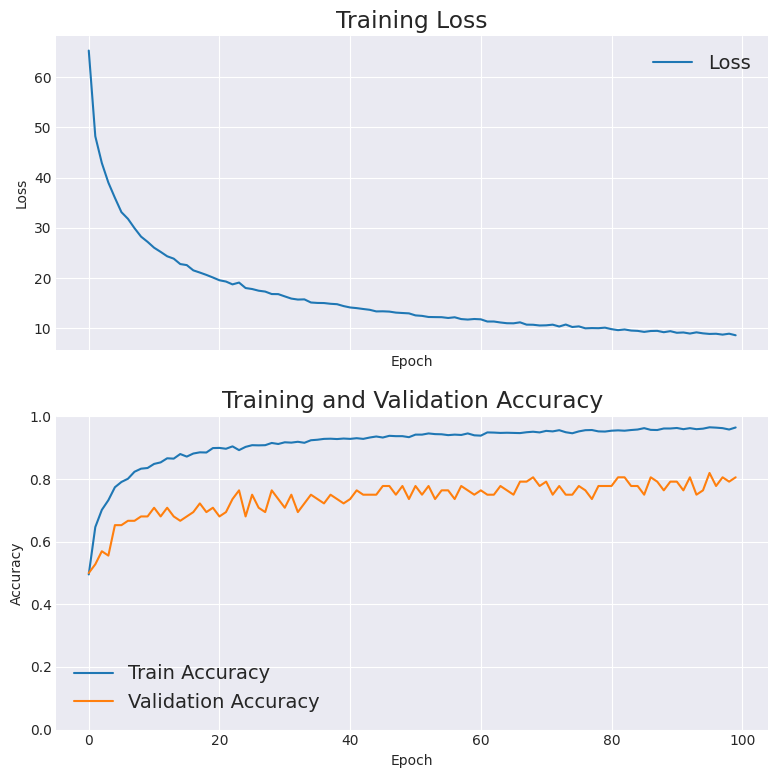

In [4]:
# Load the training data
data_train = torch.load('data_images/train.pt')
X_train = data_train['Features'][:, :]  # shape: (N, H)
Y_train = data_train['Targets'][:]  # shape: (N,)

train_ds = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)


model = SimpleNN(X_train, Y_train)
# print(summary(model, input_size=X_train.shape[1:]))

train_model(model, train_loader, val_loader, epochs=100)
evaluate_metrics(model, test_loader)

plt.savefig('Method1.png')


# 2. Data augmentation su determinate classi

Training data shape: torch.Size([1839, 512]), torch.Size([1839])
(False, tensor([0, 1, 2, 3]), tensor([585, 345, 444, 465]))
initial counts:  tensor([0, 1, 2, 3]) tensor([195, 115, 148, 155])
initial length:  613
final counts:  tensor([0, 1, 2, 3]) tensor([195, 195, 195, 195])
final length:  780
Linear(in_features=512, out_features=4, bias=True)
Epoch 1/100 | Train Loss: 31.021 | Train Acc: 0.444 | Val Acc: 0.472
Epoch 2/100 | Train Loss: 22.825 | Train Acc: 0.635 | Val Acc: 0.625
Epoch 3/100 | Train Loss: 19.999 | Train Acc: 0.694 | Val Acc: 0.542
Epoch 4/100 | Train Loss: 18.593 | Train Acc: 0.709 | Val Acc: 0.639
Epoch 5/100 | Train Loss: 17.178 | Train Acc: 0.740 | Val Acc: 0.583
Epoch 6/100 | Train Loss: 16.292 | Train Acc: 0.736 | Val Acc: 0.597
Epoch 7/100 | Train Loss: 14.837 | Train Acc: 0.792 | Val Acc: 0.639
Epoch 8/100 | Train Loss: 14.353 | Train Acc: 0.791 | Val Acc: 0.514
Epoch 9/100 | Train Loss: 13.510 | Train Acc: 0.813 | Val Acc: 0.569
Epoch 10/100 | Train Loss: 12.9

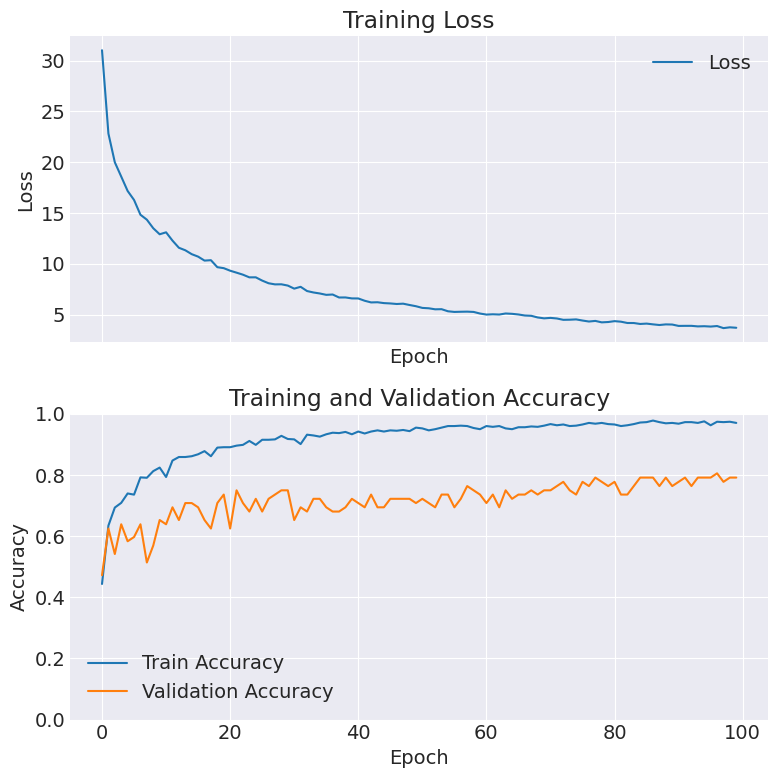

In [5]:
data_train = torch.load('data_images/train.pt')

x = data_train['Features']  # shape: (N, H)
y = data_train['Targets']  # shape: (N,)

print(f"Training data shape: {x.shape}, {y.shape}")

print(augmenting.check_balanced(x, y))

X_train, Y_train = augmenting.balance(x, y, idx=613)

# Create DataLoaders
train_ds = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model = SimpleNN(X_train, Y_train)

train_model(model, train_loader, val_loader, epochs=100)
evaluate_metrics(model, test_loader)

plt.savefig('Method2.png')

# 3. Loss pesata sulle classi piccole 
-> Più utile nella classificazione binaria dove le classi sono più sbilanciate

Training data shape: torch.Size([613, 512]), torch.Size([613])
(False, tensor([0, 1, 2, 3]), tensor([195, 115, 148, 155]))
Linear(in_features=512, out_features=4, bias=True)
Epoch 1/100 | Train Loss: 26.993 | Train Acc: 0.346 | Val Acc: 0.431
Epoch 2/100 | Train Loss: 20.963 | Train Acc: 0.507 | Val Acc: 0.417
Epoch 3/100 | Train Loss: 18.442 | Train Acc: 0.592 | Val Acc: 0.556
Epoch 4/100 | Train Loss: 16.823 | Train Acc: 0.661 | Val Acc: 0.556
Epoch 5/100 | Train Loss: 15.554 | Train Acc: 0.698 | Val Acc: 0.583
Epoch 6/100 | Train Loss: 14.634 | Train Acc: 0.742 | Val Acc: 0.569
Epoch 7/100 | Train Loss: 13.923 | Train Acc: 0.728 | Val Acc: 0.583
Epoch 8/100 | Train Loss: 13.517 | Train Acc: 0.752 | Val Acc: 0.583
Epoch 9/100 | Train Loss: 12.508 | Train Acc: 0.796 | Val Acc: 0.556
Epoch 10/100 | Train Loss: 11.892 | Train Acc: 0.790 | Val Acc: 0.597
Epoch 11/100 | Train Loss: 11.460 | Train Acc: 0.812 | Val Acc: 0.583
Epoch 12/100 | Train Loss: 11.389 | Train Acc: 0.819 | Val Acc: 0

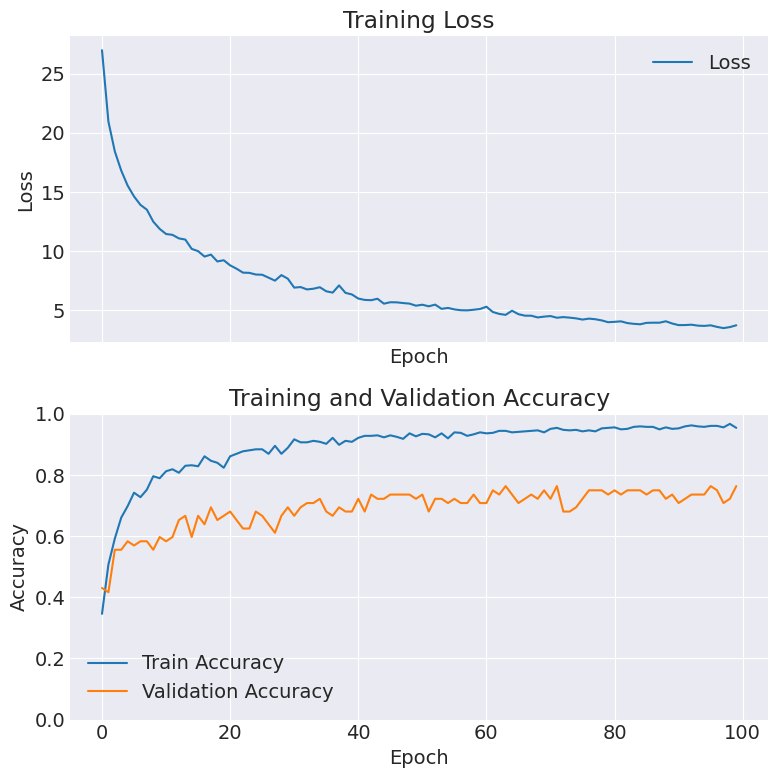

In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np # numpy is also needed for np.unique

# Load the training data
data_train = torch.load('data_images/train.pt')
X_train = data_train['Features'][:613, :]  # shape: (N, H)
Y_train = data_train['Targets'][:613]  # shape: (N,)

print(f"Training data shape: {X_train.shape}, {Y_train.shape}")

# Create DataLoaders
train_ds = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

print(augmenting.check_balanced(X_train, Y_train))

weights = torch.tensor(compute_class_weight('balanced', classes=np.unique(y), y=y.numpy()), dtype=torch.float32)

model = SimpleNN(X_train, Y_train)
model.criterion = nn.CrossEntropyLoss(weight=weights)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

train_model(model, train_loader, val_loader, epochs=100)
evaluate_metrics(model, test_loader)


plt.savefig('Method3.png')

# 4. Import images, preprocess them using resnet with fc=Identity() then train the same simple network

/home/user/DAML-project/data_images


/home/user/DAML-project/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/DAML-project/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


starting
Linear(in_features=512, out_features=4, bias=True)
Epoch 1/100 | Train Loss: 23.958 | Train Acc: 0.450 | Val Acc: 0.528
Epoch 2/100 | Train Loss: 19.784 | Train Acc: 0.569 | Val Acc: 0.472
Epoch 3/100 | Train Loss: 17.223 | Train Acc: 0.657 | Val Acc: 0.528
Epoch 4/100 | Train Loss: 16.334 | Train Acc: 0.697 | Val Acc: 0.528
Epoch 5/100 | Train Loss: 15.145 | Train Acc: 0.657 | Val Acc: 0.625
Epoch 6/100 | Train Loss: 14.253 | Train Acc: 0.721 | Val Acc: 0.597
Epoch 7/100 | Train Loss: 13.680 | Train Acc: 0.752 | Val Acc: 0.583
Epoch 8/100 | Train Loss: 14.406 | Train Acc: 0.690 | Val Acc: 0.653
Epoch 9/100 | Train Loss: 12.290 | Train Acc: 0.768 | Val Acc: 0.667
Epoch 10/100 | Train Loss: 11.740 | Train Acc: 0.809 | Val Acc: 0.597
Epoch 11/100 | Train Loss: 11.414 | Train Acc: 0.811 | Val Acc: 0.681
Epoch 12/100 | Train Loss: 10.936 | Train Acc: 0.819 | Val Acc: 0.694
Epoch 13/100 | Train Loss: 10.595 | Train Acc: 0.830 | Val Acc: 0.667
Epoch 14/100 | Train Loss: 10.712 | Tra

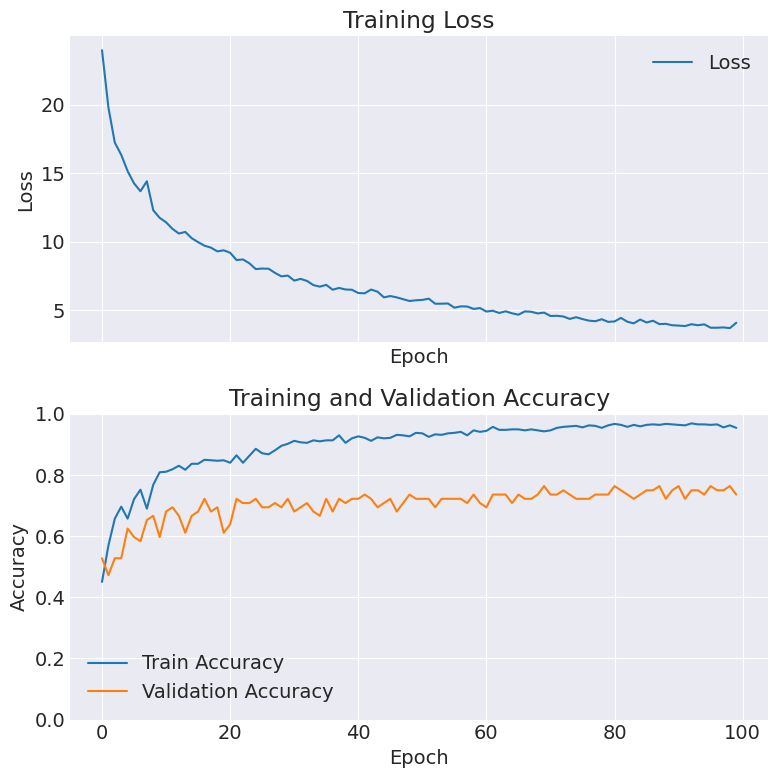

In [7]:
dataset_path = os.path.join(os.getcwd(), 'data_images')
print(dataset_path)

# Mean e std per immagini RGB normalizzate su [-1, 1]
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), 
                                     transform=custom_transforms.base_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "valid"), 
                                   transform=custom_transforms.base_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "test"), 
                                   transform=custom_transforms.base_transform)

train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

model = resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Identity()

if True:  # Change to True if you want to train the model
    model.eval()
    with torch.no_grad():
        for inputs, labels in train_loader:
            print("starting")
            outputs = model(inputs)
            mapped_data_train = outputs
            labels_train = labels
        for inputs, labels in val_loader:
            outputs = model(inputs)
            mapped_data_val = outputs
            labels_val = labels
        for inputs, labels in test_loader:
            outputs = model(inputs)
            mapped_data_test = outputs
            labels_test = labels

    train_ds = TensorDataset(mapped_data_train, labels_train)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

    val_ds = TensorDataset(mapped_data_val, labels_val)
    val_loader = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

    test_ds = TensorDataset(mapped_data_test, labels_test)
    test_loader = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

    model = SimpleNN(mapped_data_train, labels_train)
    train_model(model, train_loader, val_loader, epochs=100)
    evaluate_metrics(model, test_loader)

# Train resnet with fc=nn.Linear() -> Bad results
Takes around 36s/epoch on my machine

/home/user/DAML-project/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/DAML-project/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100 | Train Loss: 24.247 | Train Acc: 0.470 | Val Acc: 0.417
Epoch 2/100 | Train Loss: 18.844 | Train Acc: 0.625 | Val Acc: 0.542
Epoch 3/100 | Train Loss: 16.206 | Train Acc: 0.692 | Val Acc: 0.542
Epoch 4/100 | Train Loss: 15.671 | Train Acc: 0.705 | Val Acc: 0.542
Epoch 5/100 | Train Loss: 13.581 | Train Acc: 0.767 | Val Acc: 0.583
Epoch 6/100 | Train Loss: 12.461 | Train Acc: 0.793 | Val Acc: 0.653
Epoch 7/100 | Train Loss: 12.029 | Train Acc: 0.791 | Val Acc: 0.611
Epoch 8/100 | Train Loss: 11.884 | Train Acc: 0.790 | Val Acc: 0.639
Epoch 9/100 | Train Loss: 11.133 | Train Acc: 0.829 | Val Acc: 0.597
Epoch 10/100 | Train Loss: 10.255 | Train Acc: 0.848 | Val Acc: 0.681
Epoch 11/100 | Train Loss: 10.120 | Train Acc: 0.832 | Val Acc: 0.681
Epoch 12/100 | Train Loss: 9.750 | Train Acc: 0.832 | Val Acc: 0.708
Epoch 13/100 | Train Loss: 9.099 | Train Acc: 0.855 | Val Acc: 0.722
Epoch 14/100 | Train Loss: 9.582 | Train Acc: 0.853 | Val Acc: 0.639
Epoch 15/100 | Train Loss: 8.561

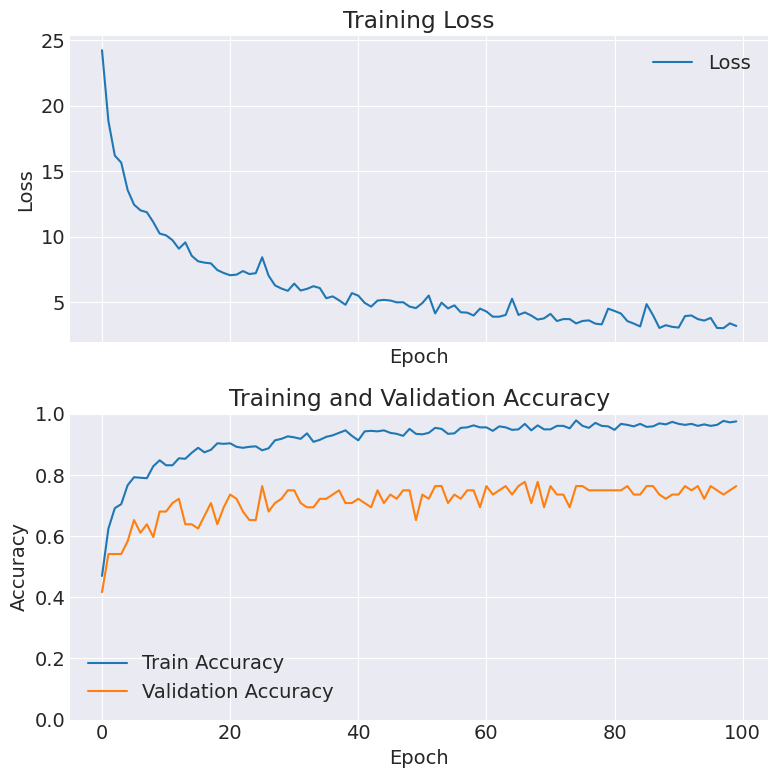

In [8]:
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), 
                                     transform=custom_transforms.base_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "valid"), 
                                   transform=custom_transforms.base_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

model = resnet18(pretrained=True)

model.fc = nn.Linear(512, 4)
# model.fc = SimpleNN(X_train, Y_train)

# model.eval()
# with torch.no_grad():
#     for inputs, labels in train_loader:
#         print("starting")
#         outputs = model(inputs)
#         mapped_data = outputs

# model = SimpleNN(mapped_data, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.criterion = nn.CrossEntropyLoss()
model.optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
model.scheduler = optim.lr_scheduler.StepLR(model.optimizer, step_size=10, gamma=gamma)

train_model(model, train_loader, val_loader, epochs=100)
# evaluate_metrics(model, test_loader)

In [9]:
torch.save(model.state_dict(), "resnet18_finetuned.pth")

/home/user/DAML-project/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/DAML-project/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/100 | Train Loss: 25.771 | Train Acc: 0.383 | Val Acc: 0.444
Epoch 2/100 | Train Loss: 19.574 | Train Acc: 0.582 | Val Acc: 0.417
Epoch 3/100 | Train Loss: 17.333 | Train Acc: 0.646 | Val Acc: 0.528
Epoch 4/100 | Train Loss: 15.447 | Train Acc: 0.719 | Val Acc: 0.514
Epoch 5/100 | Train Loss: 13.371 | Train Acc: 0.781 | Val Acc: 0.583
Epoch 6/100 | Train Loss: 12.809 | Train Acc: 0.790 | Val Acc: 0.597
Epoch 7/100 | Train Loss: 12.261 | Train Acc: 0.798 | Val Acc: 0.583
Epoch 8/100 | Train Loss: 11.459 | Train Acc: 0.817 | Val Acc: 0.611
Epoch 9/100 | Train Loss: 11.120 | Train Acc: 0.827 | Val Acc: 0.653
Epoch 10/100 | Train Loss: 10.982 | Train Acc: 0.832 | Val Acc: 0.708
Epoch 11/100 | Train Loss: 10.228 | Train Acc: 0.847 | Val Acc: 0.694
Epoch 12/100 | Train Loss: 9.597 | Train Acc: 0.856 | Val Acc: 0.681
Epoch 13/100 | Train Loss: 9.865 | Train Acc: 0.845 | Val Acc: 0.694
Epoch 14/100 | Train Loss: 8.814 | Train Acc: 0.883 | Val Acc: 0.694
Epoch 15/100 | Train Loss: 8.516

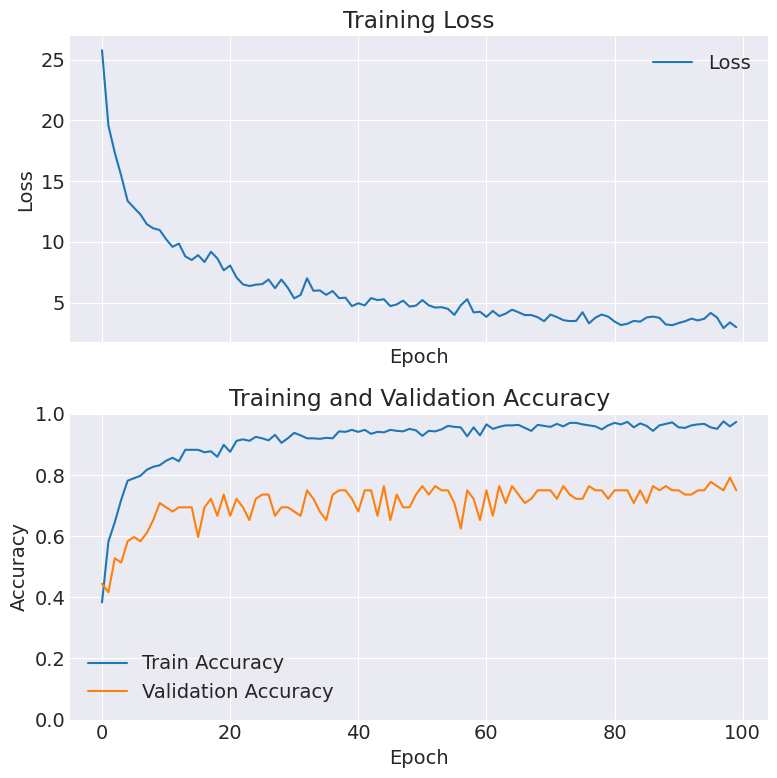

In [10]:
train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), 
                                     transform=custom_transforms.base_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "valid"), 
                                   transform=custom_transforms.base_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

model = resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 4)
# model.fc = SimpleNN(X_train, Y_train)

# model.eval()
# with torch.no_grad():
#     for inputs, labels in train_loader:
#         print("starting")
#         outputs = model(inputs)
#         mapped_data = outputs

# model = SimpleNN(mapped_data, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.criterion = nn.CrossEntropyLoss()
model.optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
model.scheduler = optim.lr_scheduler.StepLR(model.optimizer, step_size=10, gamma=gamma)

train_model(model, train_loader, val_loader, epochs=100)
# evaluate_metrics(model, test_loader)

In [11]:
torch.save(model.state_dict(), "resnet18_feature_extraction.pth")

# TODO: Train resnet both ways but using batches instead of preprocessing results in one batch

# Bonus: Early stopping

In [12]:
# passo i pesi come parametro in maniera tale che durante il training gli errori sulle classi meno frequenti abbiano un peso maggiore e quindi il modello sarà incentivato a non "ignorare" quelle classi.

# criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)


# ----------- EARLY STOPPING ------------
# # Early stopping logic
# if val_loss < best_val_loss:
#     best_val_loss = val_loss
#     epochs_without_improvement = 0
#     best_model_state = model.state_dict()  # salva il miglior modello
# else:
#     epochs_without_improvement += 1
#     print(f"  [EarlyStopping] No improvement for {epochs_without_improvement} epoch(s)")

# if epochs_without_improvement >= patience:
#     print("Early stopping triggered. Restoring best model weights.")
#     model.load_state_dict(best_model_state)
#     break